# Control Systems Tutorial 
## Part A: Cable car dynamics

### The cable car model
The cable car has four states associated with the slider position and the angle of its suspension cable. The differential equation with states $(\varphi, \omega, x, v)\in [0, 2\pi) \times \mathbb{R}^3$ reads
$$\begin{align*}
M \ddot{x} &=  -\gamma \dot{x} - T(\varphi, \dot{\varphi}, \ddot{x}) \sin \varphi + F_\mathrm{c}\\
m \ddot{\varphi} &= -mg/l \sin \varphi + \cos \varphi \cdot \ddot{x} m
\end{align*}$$
where $v = \dot{x}$, $\omega = \dot{\varphi}$. 
The line tension is $$ T(\varphi, \dot{\varphi}, \ddot{x}) = mg \cos\varphi + m l \dot{\varphi}^2 - m l \ddot{x} \sin \varphi$$

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import numpy as np
import matplotlib.pyplot as plt 
import control as ct
import control.optimal as opt
# from scipy.integrate import solve_ivp
from source.cablecar_model import cablecar_ode, cablecar_smallangle_ode, cablecar_output

# System parameters 
M = 100; m = 900; l = 5.0; g = 9.81; gammax = 20.0; gammaphi = 2.0

cablecar_params = {
    "M": M,           # mass of the slider
    "m": m,         # mass of the cable car
    "l": l,         # length of the suspension cable
    "g": g,         # gravitational acceleration
    "gammax": gammax,       # damping of the slider
    "gammaphi": gammaphi,       # damping of the cable car
}

cablecar_sys = ct.nlsys(
    cablecar_ode, cablecar_output, name='cablecar',
    params=cablecar_params, states=['phi', 'omega', 'x', 'v'],
    outputs=['phi', 'omega', 'x', 'v'], inputs=['F'])
cablecar_smallangle_sys = ct.nlsys(
    cablecar_smallangle_ode, cablecar_output, name='cablecar',
    params=cablecar_params, states=['phi', 'omega', 'x', 'v'],
    outputs=['phi', 'omega', 'x', 'v'], inputs=['F'])

In [31]:
# Stable Steady state phase angle (analytical solution)

print(f"Stable steady state at x")
x0, u0 = [-0.1, 0.0, 0.0, 0.0], [0.0]
xeq, ueq = ct.find_operating_point(cablecar_sys, x0, u0)

Stable steady state at x


In [32]:
xeq

array([-1.00974196e-28,  7.84138466e-32,  2.38393520e+01,  0.00000000e+00])

In [33]:
xeq, ueq = ct.find_operating_point(cablecar_smallangle_sys, x0, u0)

In [34]:
xeq

array([-1.30846756e-27, -9.67925890e-35,  1.25144366e-01,  1.89269692e-34])

In [35]:
# Linearisation of the system around the stable steady state
cablecar_sys_linear = ct.linearize(cablecar_sys, xeq, ueq) 


In [36]:
# check eigenvalues of the linearised system
np.linalg.eigvals(cablecar_sys_linear.A) 

array([ 0.        +0.j        , -0.00151092+1.47646709j,
       -0.00151092-1.47646709j, -0.02000039+0.j        ])

In [56]:
timepts = np.linspace(0, 20, 200)  # time points for simulation
# Input signal U (force) =1 until t=5, then 0
U = np.where(timepts <= 1.0, 200, 0.0)

resp = ct.input_output_response(cablecar_sys, timepts, U, xeq, cablecar_params)

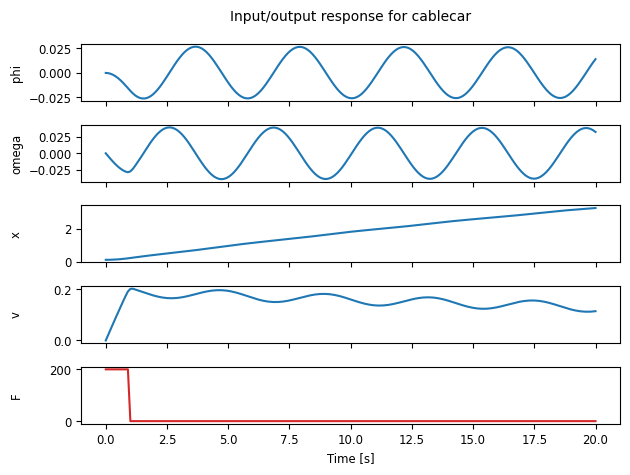

In [57]:
cplt = resp.plot() 

In [60]:
resp_smallangle = ct.input_output_response(cablecar_smallangle_sys, timepts, U, xeq, cablecar_params)

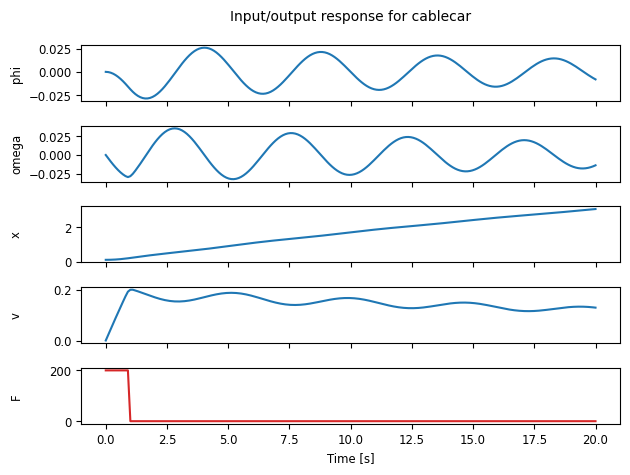

In [61]:
cplt = resp_smallangle.plot() 

In [62]:

resp_linear = ct.input_output_response(cablecar_sys_linear, timepts, U, xeq, cablecar_params)

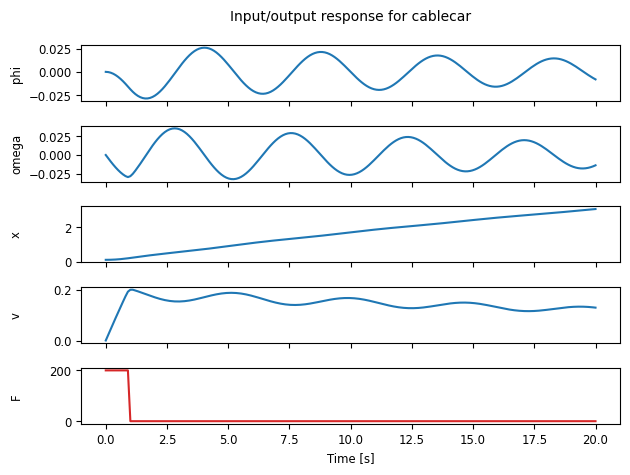

In [63]:
cplt = resp_smallangle.plot() 

In [8]:
# Phase portrait of the system

In [9]:
# root locus

In [10]:
# State-feedback controller
def control_output(t, x, z, params):
    # Get the parameters for the model
    K = params.get('K', np.zeros((2, 3)))   # nominal gain

    # Split up the input to the controller into the desired state and nominal input
    xd = z[0]    # desired position ('x*')

    # Compute the control law
    return - K @ (x - xd)

# Set-up LQR Cost function 

In [11]:
# Define the controller system
K = 10.0
cablecar_control = ct.nlsys(
    None, control_output, name='control',
    inputs=['x', 'v'],
    outputs=['F'], params={'K': K})

In [12]:
# Build the closed loop system
vehicle_closed = ct.interconnect(
    (cablecar_sys, cablecar_control),
    inputs=['xd', 'yd', 'thetad', 'vd', 'deltad'],
    outputs=['x', 'y', 'theta']
)


ValueError: could not find signal xd